### Walmart Sales Analysis

#### Importing Libs

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


#### Loading Data

In [136]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
# data = pd.read_csv("features.csv", parse_dates=["Date"], index_col=["Date"])
# data

In [137]:
features.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


In [138]:
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


In [139]:
test.head(3)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False


In [140]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


#### Merge

In [141]:
data = train.merge(features, how="left").merge(stores, how="left")
data.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315


#### Cleaning Data

In [142]:
data.shape

(421570, 16)

In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


Checking for missing values

In [144]:
missing_vals = data.isna().sum()/len(data)
missing_vals

Store           0.000000
Dept            0.000000
Date            0.000000
Weekly_Sales    0.000000
IsHoliday       0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
Type            0.000000
Size            0.000000
dtype: float64

Dropping Columns with more than 15%

In [145]:
# Removing null values from columns greater than 15%
columns_to_drop_from = missing_vals[missing_vals >= 0.15].index
clean_data = data.drop(columns=columns_to_drop_from)

Checking for duplicate values or date

In [146]:
clean_data.index.duplicated().sum()

0

In [147]:
clean_data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000


In [148]:
clean_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


In [149]:
# correcting the date column dtype
# clean_data["Date"] = clean_data["Date"].astype("datetime64[ns]")
clean_data["Date"] = pd.to_datetime(clean_data["Date"])

In [150]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   CPI           421570 non-null  float64       
 8   Unemployment  421570 non-null  float64       
 9   Type          421570 non-null  object        
 10  Size          421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 32.6+ MB


Setting the Index to date

In [151]:
clean_data = clean_data.set_index("Date")

In [152]:
clean_data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
Date,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
2010-02-26,1,1,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
2010-03-05,1,1,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


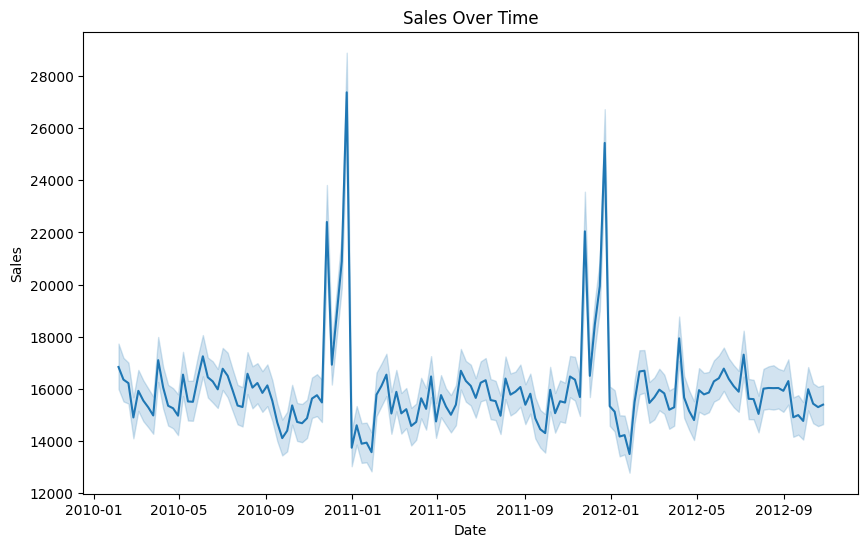

In [153]:
# Visualize the data
plt.figure(figsize=(10, 6))
sns.lineplot(x=clean_data.index, y=clean_data['Weekly_Sales'])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Setting the frequency of the data

In [154]:
clean_data["Weekly_Sales"]

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
                ...   
2012-09-28      508.37
2012-10-05      628.10
2012-10-12     1061.02
2012-10-19      760.01
2012-10-26     1076.80
Name: Weekly_Sales, Length: 421570, dtype: float64

In [155]:
clean_data.index.duplicated().sum()

421427

In [156]:
# Remove duplicate dates
clean_data = clean_data[~clean_data.index.duplicated(keep='first')]

In [157]:
clean_data.index.duplicated().sum()

0

In [158]:
clean_data

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
Date,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
2010-02-26,1,1,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
2010-03-05,1,1,21827.90,False,46.50,2.625,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1,1,18947.81,False,76.08,3.666,222.981658,6.908,A,151315
2012-10-05,1,1,21904.47,False,68.55,3.617,223.181477,6.573,A,151315
2012-10-12,1,1,22764.01,False,62.99,3.601,223.381296,6.573,A,151315


Decomposing the time series (Trend, Seasonality, Residuals)

In [159]:
# Decompose the time series
decomposition = seasonal_decompose(clean_data["Weekly_Sales"], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

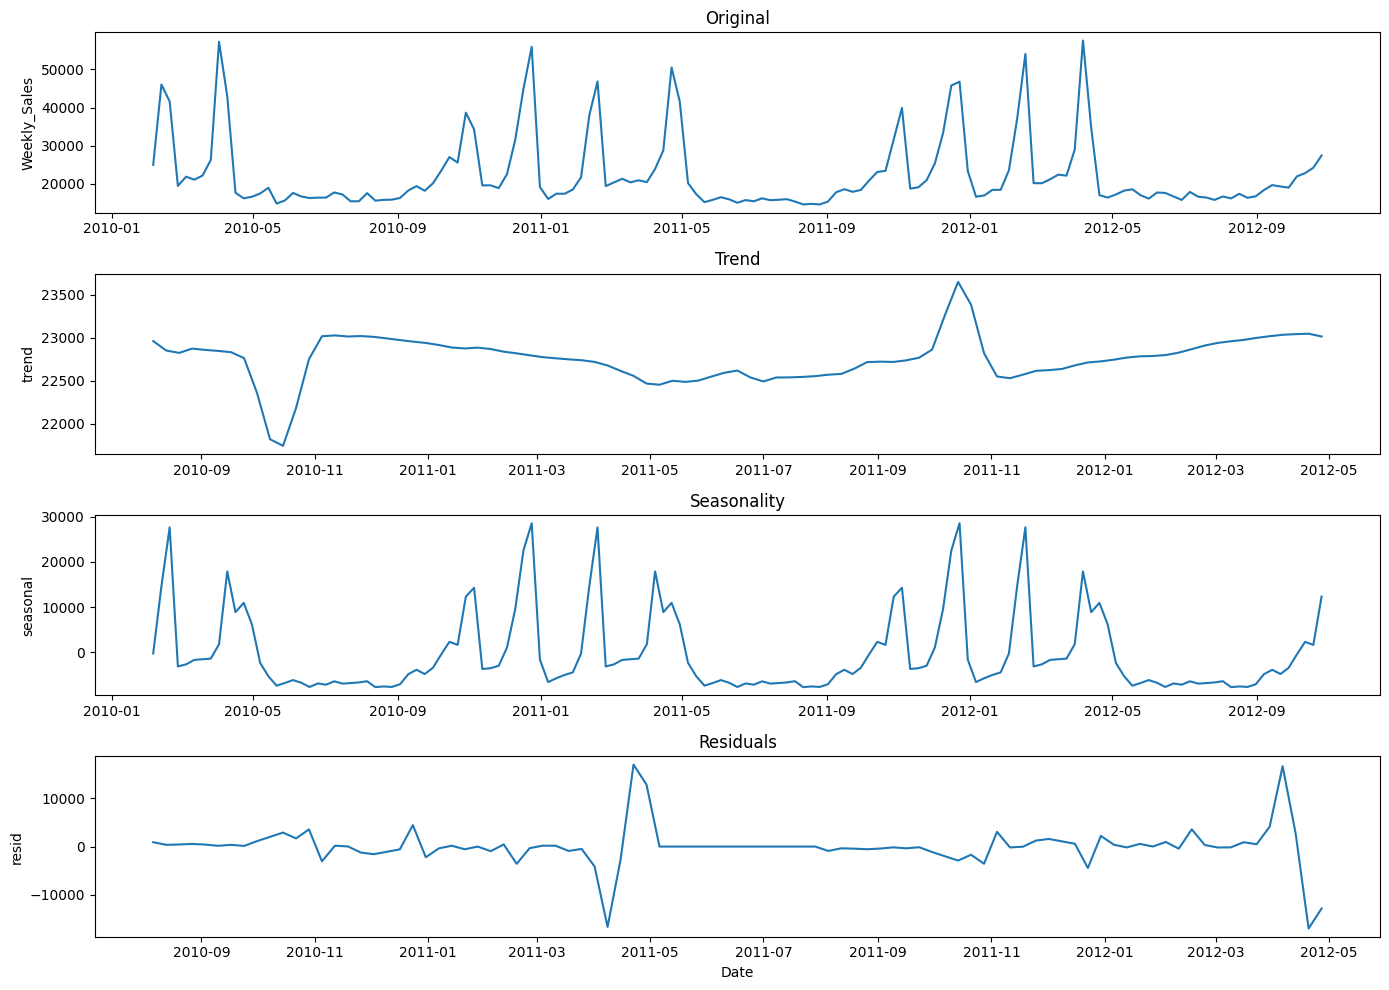

In [160]:
plt.figure(figsize=(14, 10))

plt.subplot(411)
sns.lineplot(x=clean_data.index, y=clean_data['Weekly_Sales'])
plt.title('Original')
plt.xlabel('')

plt.subplot(412)
sns.lineplot(x=trend.index, y=trend)
plt.title('Trend')
plt.xlabel('')

plt.subplot(413)
sns.lineplot(x=seasonal.index, y=seasonal)
plt.title('Seasonality')
plt.xlabel('')

plt.subplot(414)
sns.lineplot(x=residual.index, y=residual)
plt.title('Residuals')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

Stationary Check (if p-value is lower 0.05 the data is stationary)

In [161]:
# Check for stationarity
result = adfuller(clean_data['Weekly_Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.5221638686500403
p-value: 0.11017432282586914


data is non-stationary

Differencing to make the series stationary

In [162]:
# Differencing to make the series stationary if necessary
clean_data['Sales_diff'] = clean_data['Weekly_Sales'].diff()
clean_data = clean_data.dropna()

In [163]:
result = adfuller(clean_data['Sales_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -11.044311466768816
p-value: 5.269934445888216e-20


In [164]:
clean_data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Sales_diff
Date,,,,,,,,,,,
2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,21114.99
2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,-4443.94
2010-02-26,1,1,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,-22192.01
2010-03-05,1,1,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,2424.36
2010-03-12,1,1,21043.39,False,57.79,2.667,211.380643,8.106,A,151315,-784.51


### Resampling and Interpolating the data to make it consistent

In [165]:
# Resample to Daily frequency
new_data = clean_data[['Weekly_Sales', 'Fuel_Price', 'Sales_diff']]
data_resampled = new_data.resample('D').mean()

data_interpolated = data_resampled.interpolate(method='time')

Building An Arima Model

In [178]:
# Split the data into training and test sets
train_size = int(len(data_interpolated) * 0.8)  # Using 80% of the data for training
train, test = data_interpolated.iloc[:train_size], data_interpolated.iloc[train_size:]


In [179]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [180]:
pm.auto_arima(train['Weekly_Sales'])

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

In [181]:
# Fit an ARIMA model
model = ARIMA(train['Weekly_Sales'], order=(2,0,0))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  790
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -6313.470
Date:                Thu, 18 Jul 2024   AIC                          12634.940
Time:                        19:08:15   BIC                          12653.628
Sample:                    02-12-2010   HQIC                         12642.124
                         - 04-11-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.339e+04   3058.304      7.648      0.000    1.74e+04    2.94e+04
ar.L1          1.8506      0.013    142.389      0.000       1.825       1.876
ar.L2         -0.8705      0.015    -58.506      0.000      -0.900      -0.841
sigma2      5.053e+05   1.71e+04     29.605      0.000    4.72e+05    5.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             37880.11
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                            -2.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
# Forecast on the test set
forecast_steps = len(test)
forecast = fit.forecast(steps=forecast_steps)

# Create a DataFrame for the forecasted data
forecast_index = test.index
forecast_df = pd.DataFrame({'Forecast': forecast, 'Actual':test['Weekly_Sales']}, index=forecast_index)

# Calculate accuracy metrics
mae = mean_absolute_error(test['Weekly_Sales'], forecast)
mse = mean_squared_error(test['Weekly_Sales'], forecast)
rmse = np.sqrt(mse)


In [183]:
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 4896.16
Mean Squared Error (MSE): 30006501.39
Root Mean Squared Error (RMSE): 5477.82


In [184]:
# # Forecast
# forecast = fit.forecast(steps=12)
# print(f"Forecast {forecast}")
# # print(f"Standard Error {stderr}")
# # print(f"Coefficient {conf_int}")
# print(forecast)
# forecast.to_frame()

In [185]:
forecast_df

,Forecast,Actual
Date,,
2012-04-12,38026.080534,37956.768571
2012-04-13,34946.817882,34684.210000
2012-04-14,32036.668443,32154.492857
2012-04-15,29331.557683,29624.775714
2012-04-16,26858.685220,27095.058571
...,...,...
2012-10-22,23391.082659,25559.072857
2012-10-23,23391.078429,26017.007143
2012-10-24,23391.074239,26474.941429


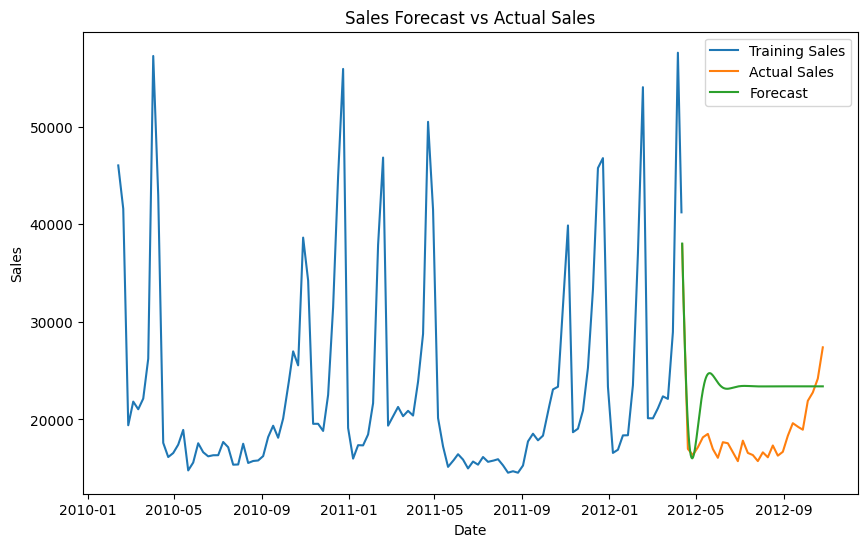

In [186]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=train.index, y=train['Weekly_Sales'], label='Training Sales')
sns.lineplot(x=test.index, y=test['Weekly_Sales'], label='Actual Sales')
sns.lineplot(x=forecast_df.index, y=forecast_df['Forecast'], label='Forecast')
plt.title('Sales Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


#### Trying Prophet Model

In [187]:
from prophet import Prophet as pt

In [188]:
train.reset_index(inplace=True)

In [189]:
train.rename(columns={'Date':'ds', 'Weekly_Sales':'y'}, inplace=True)
train

C:\Users\Great Speed\AppData\Local\Temp\ipykernel_6868\3200647448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'Date':'ds', 'Weekly_Sales':'y'}, inplace=True)


,ds,y,Fuel_Price,Sales_diff
0,2010-02-12,46039.490000,2.548000,21114.990000
1,2010-02-13,45404.641429,2.543143,17463.714286
2,2010-02-14,44769.792857,2.538286,13812.438571
3,2010-02-15,44134.944286,2.533429,10161.162857
4,2010-02-16,43500.095714,2.528571,6509.887143
...,...,...,...,...
785,2012-04-07,54319.561429,3.891000,21275.378571
786,2012-04-08,51047.002857,3.891000,13911.497143
787,2012-04-09,47774.444286,3.891000,6547.615714
788,2012-04-10,44501.885714,3.891000,-816.265714


In [190]:
model = pt()
model.fit(train)

19:08:17 - cmdstanpy - INFO - Chain [1] start processing
19:08:17 - cmdstanpy - INFO - Chain [1] done processing


In [191]:
future = model.make_future_dataframe(len(test), include_history=False)
future

,ds
0,2012-04-12
1,2012-04-13
2,2012-04-14
3,2012-04-15
4,2012-04-16
...,...
193,2012-10-22
194,2012-10-23
195,2012-10-24
196,2012-10-25


In [192]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower',
          'yhat_upper', 'trend',
          'trend_lower', 'trend_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
188,2012-10-17,29506.523687,22842.330267,36856.795303,26548.155590,26250.062369,26861.434797
189,2012-10-18,30348.944219,23858.338768,37139.916040,26558.395625,26258.493945,26873.032249
190,2012-10-19,31316.607952,24539.325140,37509.643373,26568.635659,26265.776855,26885.074562
191,2012-10-20,32183.250759,25486.368136,39054.500908,26578.875694,26272.801772,26897.563450
192,2012-10-21,33037.097350,26291.349332,39681.713536,26589.115728,26278.934731,26910.052337
193,2012-10-22,33862.025382,27426.706835,40664.892429,26599.355763,26286.420089,26922.541225
194,2012-10-23,34641.652791,28231.391123,41506.107797,26609.595797,26294.365726,26936.460422
195,2012-10-24,35359.696161,28821.658173,42297.258018,26619.835832,26303.805276,26950.474469
196,2012-10-25,35988.625085,29741.680318,42872.467027,26630.075866,26312.973379,26964.304606
197,2012-10-26,36634.089157,30017.832444,42965.039591,26640.315901,26322.141482,26976.639950


In [203]:
test = test.reset_index()
forecast_df = pd.DataFrame({'Forecast': forecast['yhat'], 'Actual':test['Weekly_Sales'], 'upper':forecast['yhat_upper'], 'lower':forecast['yhat_lower']})

In [204]:
forecast_df

,Forecast,Actual,upper,lower
0,36634.053774,37956.768571,43331.829392,29704.470702
1,36309.715941,34684.210000,43366.271056,29654.665757
2,35835.604366,32154.492857,42462.020165,29337.292457
3,35323.378012,29624.775714,42194.257349,28745.742465
4,34780.561235,27095.058571,41497.770226,28117.249393
...,...,...,...,...
193,33862.025382,25559.072857,40664.892429,27426.706835
194,34641.652791,26017.007143,41506.107797,28231.391123
195,35359.696161,26474.941429,42297.258018,28821.658173
196,35988.625085,26932.875714,42872.467027,29741.680318


In [201]:
# Calculate accuracy metrics
mae = mean_absolute_error(test['Weekly_Sales'], forecast['yhat'])
mse = mean_squared_error(test['Weekly_Sales'], forecast['yhat'])
rmse = np.sqrt(mse)


In [202]:
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 3453.78
Mean Squared Error (MSE): 22011345.49
Root Mean Squared Error (RMSE): 4691.63


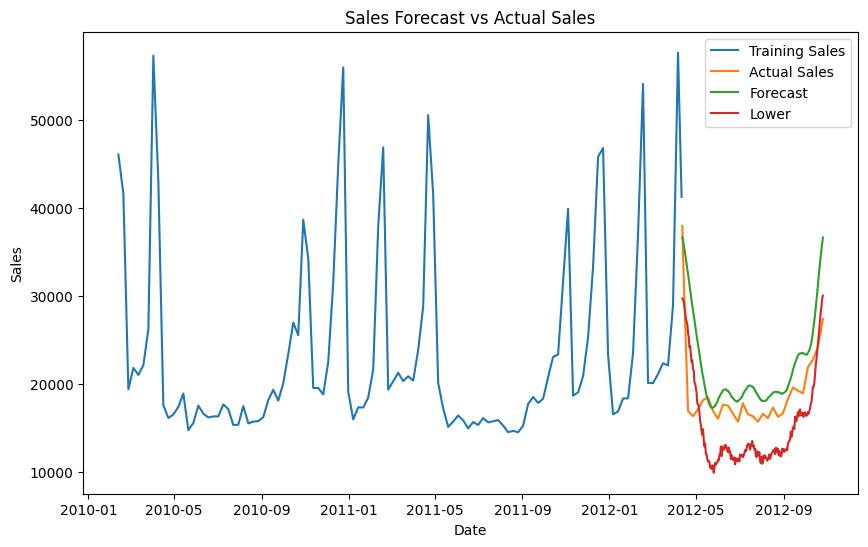

In [207]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=train['ds'], y=train['y'], label='Training Sales')
sns.lineplot(x=test['Date'], y=test['Weekly_Sales'], label='Actual Sales')
sns.lineplot(x=forecast['ds'], y=forecast['yhat'], label='Forecast')
sns.lineplot(x=forecast['ds'], y=forecast['yhat_lower'], label='Lower')
plt.title('Sales Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
